# Execute PaperMill
This notebook will: \
- set a series of parameters (param_dict)
- run them through a template, LTA_5_XCorr-Methods_template.ipynb
- this creates a new notebook LTA_6_XCorr_Methods_{tag-name}.ipynb
    - and the notebook runs the xcorr analysis
    - and saves the results to xcorr-out-{tag-name}-{year-month-dayT-Zhour}.json
- then this creates a new Cross-Correlation table
- 


In [37]:
import papermill as pm
import pandas as pd
import numpy as np

from scipy.stats import iqr, linregress, theilslopes, siegelslopes
import statsmodels.api as sm
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from IPython.display import Markdown as md
# display(md(f"## Sub Header {variable_name}"))

In [38]:
# This is a list of all of the potential sets of parameters that might get used.
# Choose which set of parameters should be executed using `run_keys`, below.
param_dict = {
    'test': {
        'analysis_tag': 'test',
        'analysis_plotting': False, # If False, no plots will be made. Much faster!
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing':  'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform', 'smooth-difference'
        'analysis_transform': 'no_transform',
        'analysis_filter_type': None,
        'analysis_filter_cutoff': None,
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [1,2],
        # Search window for best match
        # either 'full' for accepting matches of the entire dataset, 
        # or a list indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': False, #True if every segment should be detrended before cross-correlation.
    },
    'depth': {
        'analysis_tag': 'depth',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'no_transform',
        'analysis_filter_type': None,
        'analysis_filter_cutoff': None,
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': False,
    },
    'depth-900': {
        'analysis_tag': 'depth-900',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'no_transform',
        'analysis_filter_type': None,
        'analysis_filter_cutoff': None,
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 900,
        'analysis_detrend': False,
    },
    'depth-dt': {
        'analysis_tag': 'depth-dt',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'no_transform',
        'analysis_filter_type': None,
        'analysis_filter_cutoff': None,
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': True, #Detrend all of the segments before running cross-correlation.
    },
    'depth-dt-900': {
        'analysis_tag': 'depth-dt-900',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'no_transform',
        'analysis_filter_type': None,
        'analysis_filter_cutoff': None,
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 900,
        'analysis_detrend': True, #Detrend all of the segments before running cross-correlation.
    },
    'discharge': {
        'analysis_tag': 'discharge',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-discharge.parquet',
        'analysis_data_source_label': 'Discharge (m³/s)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'no_transform',
        'analysis_filter_type': None,
        'analysis_filter_cutoff': None,
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': False,
    },
    'discharge-900': {
        'analysis_tag': 'discharge-900',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-discharge.parquet',
        'analysis_data_source_label': 'Discharge (m³/s)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'no_transform',
        'analysis_filter_type': None,
        'analysis_filter_cutoff': None,
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 900,
        'analysis_detrend': False,
    },
    'discharge-dt': {
        'analysis_tag': 'discharge-dt',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-discharge.parquet',
        'analysis_data_source_label': 'Discharge (m³/s)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'no_transform',
        'analysis_filter_type': None,
        'analysis_filter_cutoff': None,
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': True,
    },
    'discharge-dt-900': {
        'analysis_tag': 'discharge-dt-900',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-discharge.parquet',
        'analysis_data_source_label': 'Discharge (m³/s)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'no_transform',
        'analysis_filter_type': None,
        'analysis_filter_cutoff': None,
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 900,
        'analysis_detrend': True,
    },
    'band1d130m': {
        'analysis_tag': 'band1d130m',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'filter',
        'analysis_filter_type': 'bandpass',
        'analysis_filter_cutoff': ['1 day','130 minutes'],
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': False,
    },
    'band1d130m-900': {
        'analysis_tag': 'band1d130m-900',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'filter',
        'analysis_filter_type': 'bandpass',
        'analysis_filter_cutoff': ['1 day','130 minutes'],
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 900,
        'analysis_detrend': False,
    },
    'band1d130m-dt': {
        'analysis_tag': 'band1d130m-dt',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'filter',
        'analysis_filter_type': 'bandpass',
        'analysis_filter_cutoff': ['1 day','130 minutes'],
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': True,
    },
    'band1d130m-dt-900': {
        'analysis_tag': 'band1d130m-dt-900',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'filter',
        'analysis_filter_type': 'bandpass',
        'analysis_filter_cutoff': ['1 day','130 minutes'],
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 900,
        'analysis_detrend': True,
    },
    'band3d130m': {
        'analysis_tag': 'band3d130m',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'filter',
        'analysis_filter_type': 'bandpass',
        'analysis_filter_cutoff': ['3 day','130 minutes'],
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': False,
    },
    'band3d130m-900': {
        'analysis_tag': 'band3d130m-900',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'filter',
        'analysis_filter_type': 'bandpass',
        'analysis_filter_cutoff': ['3 day','130 minutes'],
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 900,
        'analysis_detrend': False,
    },
    'band7d130m': {
        'analysis_tag': 'band7d130m',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'filter',
        'analysis_filter_type': 'bandpass',
        'analysis_filter_cutoff': ['7 day','130 minutes'],
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': False,
    },
    'band7d130m-900': {
        'analysis_tag': 'band7d130m-900',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'filter',
        'analysis_filter_type': 'bandpass',
        'analysis_filter_cutoff': ['7 day','130 minutes'],
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 900,
        'analysis_detrend': False,
    },
    'band7d1d': {
        'analysis_tag': 'band7d1d',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'filter',
        'analysis_filter_type': 'bandpass',
        'analysis_filter_cutoff': ['7 day','1 day'],
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': False,
    },
    'band7d1d-900': {
        'analysis_tag': 'band7d1d-900',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'filter',
        'analysis_filter_type': 'bandpass',
        'analysis_filter_cutoff': ['7 day','1 day'],
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 900,
        'analysis_detrend': False,
    },
    'band7d3d': {
        'analysis_tag': 'band7d3d',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'filter',
        'analysis_filter_type': 'bandpass',
        'analysis_filter_cutoff': ['7 day','3 day'],
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': False,
    },
    'smooth1daydiff': {
        'analysis_tag': 'smooth1daydiff',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'smooth-difference',
        'analysis_filter_type': None,
        'analysis_filter_cutoff': '1 day',
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': False,
    },
    'smooth130diff': {
        'analysis_tag': 'smooth130diff',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'smooth-difference',
        'analysis_filter_type': None,
        'analysis_filter_cutoff': '130 minutes',
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': False,
    },
        'smooth130diff-900': {
        'analysis_tag': 'smooth130diff-900',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'smooth-difference',
        'analysis_filter_type': None,
        'analysis_filter_cutoff': '130 minutes',
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 900,
        'analysis_detrend': False,
    },
    'smooth130diff-dt': {
        'analysis_tag': 'smooth130diff-dt',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'smooth-difference',
        'analysis_filter_type': None,
        'analysis_filter_cutoff': '130 minutes',
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': True,
    },
    'smooth130m': {
        'analysis_tag': 'smooth130m',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'filter',
        'analysis_filter_type': 'lowpass',
        'analysis_filter_cutoff': '130 minutes',
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': False,
    },
    'smooth130m-dt': {
        'analysis_tag': 'smooth130m-dt',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'filter',
        'analysis_filter_type': 'lowpass',
        'analysis_filter_cutoff': '130 minutes',
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': True,
    },
    'smooth1d': {
        'analysis_tag': 'smooth1d',
        'analysis_plotting': False,
        # either 'WBdata-depth.parquet' or 'WBdata-discharge.parquet'
        'analysis_data_source': 'WBdata-depth.parquet',
        'analysis_data_source_label': 'Depth (m)',
        # xcorr calls replace_na() with this method. Options: 'full' replacement; 'no' replacement; 
        'analysis_missing': 'full',
        # How to transform the data before the cross-correlation. Options are: 'filter', 'no_transform'
        'analysis_transform': 'filter',
        'analysis_filter_type': 'lowpass',
        'analysis_filter_cutoff': '1 day',
        # Choose how long the segments should be. length = total_length/2^step_size
        'analysis_levels': [0,1,2,3,4,5,6,7],
        # Search window for best match
        #either 'full' for accepting matches of the entire dataset, or a tuple indicating the min and max number of lags in which a search for a match will occur.
        'analysis_search_window': 'full',
        'analysis_detrend': False,
    },
}

In [39]:
pm.inspect_notebook('4_xcorr-method-template.ipynb')

{}

In [40]:
# Use this selection process so that the param_dict can be a full account of every set of parameters run, but you can still re-run only one set at a time.
# Make a list of every method in the param_dict that you want to run. Use the key for the method.
run_keys = [
    #'test',
    #'depth-fill-1_900',
    #'depth-fill-full',
    #'discharge-fill-1_900',
    #'band1d130m-fill-1_900',
    #'band7d1d-fill-1_900',
    #'smooth-diff-fill-1_900',
    #'band130m-fill-1_900',
    #'smooth130m-1_900-dt',
    #'discharge-daily',
    #'smooth130diff-900',
    #'band1d130m-900',
    #'smooth1daydiff',
    'band3d130m-900',
    'band7d1d-900',
    'band7d130m-900'
    
           ]

# selection is a subset of param_dict
selection = {key:param_dict[key] for key in run_keys}
#selection = {key:value for key, value in param_dict.items() if key in run_keys} # Use everything in run_keys

#selection = {key:value for key, value in param_dict.items() if key != 'test'}  # Use everything except 'test'
# selection = param_dict # Use this to run every method in the dict.

for key, parameters in selection.items():  
    print(f"Running {key} \n    Values:")
    for param, value in parameters.items():
        print(f"        {param}:  {value}")

    pm.execute_notebook(
        '4_xcorr-method-template.ipynb',
        f"6_XCorr_{key}.ipynb",
        parameters=parameters
    )



Passed unknown parameter: analysis_tag
Passed unknown parameter: analysis_plotting
Passed unknown parameter: analysis_data_source
Passed unknown parameter: analysis_data_source_label
Passed unknown parameter: analysis_missing
Passed unknown parameter: analysis_transform
Passed unknown parameter: analysis_filter_type
Passed unknown parameter: analysis_filter_cutoff
Passed unknown parameter: analysis_levels
Passed unknown parameter: analysis_search_window
Passed unknown parameter: analysis_detrend


Running band3d130m-900 
    Values:
        analysis_tag:  band3d130m-900
        analysis_plotting:  False
        analysis_data_source:  WBdata-depth.parquet
        analysis_data_source_label:  Depth (m)
        analysis_missing:  full
        analysis_transform:  filter
        analysis_filter_type:  bandpass
        analysis_filter_cutoff:  ['3 day', '130 minutes']
        analysis_levels:  [0, 1, 2, 3, 4, 5, 6, 7]
        analysis_search_window:  900
        analysis_detrend:  False


Executing:   0%|          | 0/34 [00:00<?, ?cell/s]

Passed unknown parameter: analysis_tag
Passed unknown parameter: analysis_plotting
Passed unknown parameter: analysis_data_source
Passed unknown parameter: analysis_data_source_label
Passed unknown parameter: analysis_missing
Passed unknown parameter: analysis_transform
Passed unknown parameter: analysis_filter_type
Passed unknown parameter: analysis_filter_cutoff
Passed unknown parameter: analysis_levels
Passed unknown parameter: analysis_search_window
Passed unknown parameter: analysis_detrend


Running band7d1d-900 
    Values:
        analysis_tag:  band7d1d-900
        analysis_plotting:  False
        analysis_data_source:  WBdata-depth.parquet
        analysis_data_source_label:  Depth (m)
        analysis_missing:  full
        analysis_transform:  filter
        analysis_filter_type:  bandpass
        analysis_filter_cutoff:  ['7 day', '1 day']
        analysis_levels:  [0, 1, 2, 3, 4, 5, 6, 7]
        analysis_search_window:  900
        analysis_detrend:  False


Executing:   0%|          | 0/34 [00:00<?, ?cell/s]

Passed unknown parameter: analysis_tag
Passed unknown parameter: analysis_plotting
Passed unknown parameter: analysis_data_source
Passed unknown parameter: analysis_data_source_label
Passed unknown parameter: analysis_missing
Passed unknown parameter: analysis_transform
Passed unknown parameter: analysis_filter_type
Passed unknown parameter: analysis_filter_cutoff
Passed unknown parameter: analysis_levels
Passed unknown parameter: analysis_search_window
Passed unknown parameter: analysis_detrend


Running band7d130m-900 
    Values:
        analysis_tag:  band7d130m-900
        analysis_plotting:  False
        analysis_data_source:  WBdata-depth.parquet
        analysis_data_source_label:  Depth (m)
        analysis_missing:  full
        analysis_transform:  filter
        analysis_filter_type:  bandpass
        analysis_filter_cutoff:  ['7 day', '130 minutes']
        analysis_levels:  [0, 1, 2, 3, 4, 5, 6, 7]
        analysis_search_window:  900
        analysis_detrend:  False


Executing:   0%|          | 0/34 [00:00<?, ?cell/s]

## Read the log session-parameters.json
The session log helps keep track of all of the runs; later we use it to create a table of the output

In [41]:
# Each run from above will save an entry into this session-parameters table.
session_table = pd.read_json(f"session-parameters.json", orient='table')
session_table

,analysis_tag,analysis_start,analysis_stop,analysis_runtime,analysis_filename,analysis_plotting,analysis_data_source,analysis_data_source_label,analysis_missing,analysis_transform,analysis_filter_type,analysis_filter_cutoff,analysis_levels,analysis_search_window,analysis_detrend
0,depth,2025-06-28T21:03:33Z,2025-06-28T21:03:52Z,0 days 00:00:19.107943,xcorr-out-depth-2025-06-28T21.json,False,WBdata-depth.parquet,Depth (m),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",full,False
1,depth-900,2025-06-28T21:03:59Z,2025-06-28T21:04:18Z,0 days 00:00:18.689082,xcorr-out-depth-900-2025-06-28T21.json,False,WBdata-depth.parquet,Depth (m),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",900,False
2,depth-dt,2025-06-28T21:04:26Z,2025-06-28T21:04:46Z,0 days 00:00:19.631976,xcorr-out-depth-dt-2025-06-28T21.json,False,WBdata-depth.parquet,Depth (m),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",full,True
3,depth-dt-900,2025-06-28T21:04:53Z,2025-06-28T21:05:13Z,0 days 00:00:19.932100,xcorr-out-depth-dt-900-2025-06-28T21.json,False,WBdata-depth.parquet,Depth (m),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",900,True
4,discharge,2025-06-28T21:05:21Z,2025-06-28T21:05:41Z,0 days 00:00:19.551623,xcorr-out-discharge-2025-06-28T21.json,False,WBdata-discharge.parquet,Discharge (m³/s),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",full,False
5,discharge-900,2025-06-28T21:05:49Z,2025-06-28T21:06:08Z,0 days 00:00:19.276503,xcorr-out-discharge-900-2025-06-28T21.json,False,WBdata-discharge.parquet,Discharge (m³/s),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",900,False
6,discharge-dt,2025-06-28T21:06:16Z,2025-06-28T21:06:37Z,0 days 00:00:20.753243,xcorr-out-discharge-dt-2025-06-28T21.json,False,WBdata-discharge.parquet,Discharge (m³/s),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",full,True
7,discharge-dt-900,2025-06-28T21:06:45Z,2025-06-28T21:07:04Z,0 days 00:00:19.806283,xcorr-out-discharge-dt-900-2025-06-28T21.json,False,WBdata-discharge.parquet,Discharge (m³/s),full,no_transform,NaN,NaN,"[0, 1, 2, 3, 4, 5, 6, 7]",900,True
8,band1d130m,2025-06-28T21:07:13Z,2025-06-28T21:07:31Z,0 days 00:00:18.767838,xcorr-out-band1d130m-2025-06-28T21.json,False,WBdata-depth.parquet,Depth (m),full,filter,bandpass,"[1 day, 130 minutes]","[0, 1, 2, 3, 4, 5, 6, 7]",full,False
9,band1d130m-900,2025-06-28T21:07:39Z,2025-06-28T21:07:58Z,0 days 00:00:19.202563,xcorr-out-band1d130m-900-2025-06-28T21.json,False,WBdata-depth.parquet,Depth (m),full,filter,bandpass,"[1 day, 130 minutes]","[0, 1, 2, 3, 4, 5, 6, 7]",900,False


# Create Cross-Correlation Results Table

Output from every method and the validation data will be compiled into a single table
to make it easier to compare methods.

In [42]:
display(md(f"## Select parameters for Table"))

manual = [    # Use this to manually choose which tags go into the results table.
    'depth-1_900',
    'band130m-fill-1_900',
    'depth-full',
    'depth-full-dt',
    'discharge-1_900',
    'band7d1d-1_900', 
    'band1d130m-1_900', 
    'smooth130diff-1_900',
]

drop_vals = ['test','delete-me', 'dailyQ']
from_param_keys = [x for x in param_dict.keys() if x not in drop_vals]


session_list = session_table['analysis_tag'].unique()
from_sessions = [x for x in session_list if x not in drop_vals] # This will include all of the unique tags in the session list

included = from_sessions

print(f"Manual list length: {len(manual)}")
print(f"from_param_keys list length: {len(from_param_keys)}")
print(f"from_sessions list length: {len(from_sessions)}")

## Select parameters for Table

Manual list length: 8
from_param_keys list length: 26
from_sessions list length: 26


In [43]:
display(md(f"## Create Xcorr Output Table"))

frames = []
for tag in included:
    print(f"\n{tag}", end='')
    latest = session_table.loc[session_table['analysis_tag'] == tag].iloc[-1]
    filename = latest['analysis_filename']
    print(f" --- {filename}")
    try:
        temp_table = pd.read_json(filename, orient='table')
        temp_table['method'] = tag
        frames.append(temp_table)
    except FileNotFoundError as e:
        print(f"            {e}")
output = pd.concat(frames)
output = output.set_index(['method','level', 'reach', 'segment'])

# ADD the Validation data as a method entry
#Just take the depth method and copy the validation numbers from it
valid_out = output.loc[('depth'),:].copy()
valid_out.loc[:,'celerity'] = valid_out.loc[:,'avg_val_c']
valid_out.loc[:,'lag'] = valid_out.loc[:,'avg_val_lag']/(15*60)
valid_out.loc[:,'lag_time'] = valid_out.loc[:,'avg_val_lag']
valid_out.loc[:,['resid_c', 'resid_lag']] = 0
valid_out.loc[:,'xwidth'] = 0
null_list = [ 'us_idxmax','ds_idxmax',
            'lagmax', 'xcorr',  
             'comments',            
            ]
valid_out.loc[:,null_list] = np.nan
valid_out['method'] = 'validation'
valid_out = valid_out.reset_index().set_index(['method', 'level', 'reach', 'segment'])
output = pd.concat([output, valid_out])
output.loc[('smooth130diff-dt', slice(None), slice(None), 0), 'celerity']

## Create Xcorr Output Table


depth --- xcorr-out-depth-2025-06-28T21.json

depth-900 --- xcorr-out-depth-900-2025-06-28T21.json

depth-dt --- xcorr-out-depth-dt-2025-06-28T21.json

depth-dt-900 --- xcorr-out-depth-dt-900-2025-06-28T21.json

discharge --- xcorr-out-discharge-2025-06-28T21.json

discharge-900 --- xcorr-out-discharge-900-2025-06-28T21.json

discharge-dt --- xcorr-out-discharge-dt-2025-06-28T21.json

discharge-dt-900 --- xcorr-out-discharge-dt-900-2025-06-28T21.json

band1d130m --- xcorr-out-band1d130m-2025-06-28T21.json

band1d130m-900 --- xcorr-out-band1d130m-900-2025-06-28T21.json

band1d130m-dt --- xcorr-out-band1d130m-dt-2025-06-28T21.json

band1d130m-dt-900 --- xcorr-out-band1d130m-dt-900-2025-06-28T21.json

band3d130m --- xcorr-out-band3d130m-2025-06-28T21.json

band7d130m --- xcorr-out-band7d130m-2025-06-28T21.json

band7d1d --- xcorr-out-band7d1d-2025-06-28T21.json

band7d3d --- xcorr-out-band7d3d-2025-06-28T21.json

smooth1daydiff --- xcorr-out-smooth1daydiff-2025-06-28T21.json

smooth130di

C:\Users\marti\AppData\Local\Temp\ipykernel_10232\1380053262.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 19.33333333  55.09638554  38.92553191 ... 138.         150.
          nan]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid_out.loc[:,'lag'] = valid_out.loc[:,'avg_val_lag']/(15*60)
C:\Users\marti\AppData\Local\Temp\ipykernel_10232\1380053262.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 17400.          49586.74698795  35032.9787234  ... 124200.
 135000.                     nan]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  valid_out.loc[:,'lag_time'] = valid_out.loc[:,'avg_val_lag']


method            level  reach                segment
smooth130diff-dt  0      Curwensville-Hyde    0           1.206852
                         Hyde-Karthaus        0           2.042735
                         Karthaus-Renovo      0           1.762667
                         Renovo-Williamsport  0           1.796398
                  1      Curwensville-Hyde    0           1.206852
                         Hyde-Karthaus        0           2.096491
                         Karthaus-Renovo      0           2.372821
                         Renovo-Williamsport  0           2.170648
                  2      Curwensville-Hyde    0           1.316566
                         Hyde-Karthaus        0           2.096491
                         Karthaus-Renovo      0           1.869495
                         Renovo-Williamsport  0          34.730370
                  3      Curwensville-Hyde    0           1.206852
                         Hyde-Karthaus        0           1.943089
        

In [44]:
output.columns

Index(['us', 'ds', 'US_nulls', 'DS_nulls', 'start', 'stop', 'lag', 'xcorr',
       'xwidth', 'celerity', 'raw_us_data_mean', 'raw_ds_data_mean',
       'comments', 'old_lag', 'avg_val_c', 'avg_val_lag', 'val_count',
       'resid_c', 'lag_time', 'resid_lag', 'us_idxmax', 'ds_idxmax', 'lagmax'],
      dtype='object')

In [45]:
# Calculate plausible filter for Celerity
output['plausible_c'] = output['celerity'].between(0.1, 7.0)

# Filter plausible celerities for outliers
#Finally, after working all day on it, I think I have it: 
#Create the new column, ‘in’  (for ‘inliers’ as opposed to ‘outliers’)
#Set all values to np.nan or maybe false…
#Select everything that has a plausible celerity
#Groupby method, level, reach, select celerity, and calculate the madmed rule on each group with transform
#The result has the same index as xcorr, but is shorter: it only has plausible c rows.
#Either merge or set the values 
#inlier = select.loc[select['plaus']].groupby('reach')['celerity'].transform(pg.madmedianrule)

def median_filter(group):
    if len(group) < 7:
        print(group.name, "< 7")
        result = True
    else:
        print(group.name)
        result = ~pg.madmedianrule(group)
    return result

output['inlier'] = output['plausible_c'] # It can't be an inlier if isn't plausible
plaus_mask = output['plausible_c']
output.loc[plaus_mask, 'inlier'] = output.loc[plaus_mask, 'celerity'].groupby(['method','reach','level']).transform(median_filter)


output.to_parquet('xcorr_output.parquet')
output = pd.read_parquet('xcorr_output.parquet')
#output.dtypes

('band1d130m', 'Curwensville-Hyde', 0) < 7
('band1d130m', 'Curwensville-Hyde', 1) < 7
('band1d130m', 'Curwensville-Hyde', 2) < 7
('band1d130m', 'Curwensville-Hyde', 3)
('band1d130m', 'Curwensville-Hyde', 4)
('band1d130m', 'Curwensville-Hyde', 5)
('band1d130m', 'Curwensville-Hyde', 6)
('band1d130m', 'Curwensville-Hyde', 7)
('band1d130m', 'Hyde-Karthaus', 0) < 7
('band1d130m', 'Hyde-Karthaus', 1) < 7
('band1d130m', 'Hyde-Karthaus', 2) < 7
('band1d130m', 'Hyde-Karthaus', 3)
('band1d130m', 'Hyde-Karthaus', 4)
('band1d130m', 'Hyde-Karthaus', 5)
('band1d130m', 'Hyde-Karthaus', 6)
('band1d130m', 'Hyde-Karthaus', 7)
('band1d130m', 'Karthaus-Renovo', 0) < 7
('band1d130m', 'Karthaus-Renovo', 1) < 7
('band1d130m', 'Karthaus-Renovo', 2) < 7
('band1d130m', 'Karthaus-Renovo', 3) < 7
('band1d130m', 'Karthaus-Renovo', 4)
('band1d130m', 'Karthaus-Renovo', 5)
('band1d130m', 'Karthaus-Renovo', 6)
('band1d130m', 'Karthaus-Renovo', 7)
('band1d130m', 'Renovo-Williamsport', 0) < 7
('band1d130m', 'Renovo-Will

C:\Users\marti\anaconda3\envs\py13analysis\lib\site-packages\pingouin\nonparametric.py:152: RuntimeWarning: divide by zero encountered in divide
  return (np.fabs(a - np.median(a)) / mad(a)) > k
C:\Users\marti\anaconda3\envs\py13analysis\lib\site-packages\pingouin\nonparametric.py:152: RuntimeWarning: invalid value encountered in divide
  return (np.fabs(a - np.median(a)) / mad(a)) > k


('smooth130diff', 'Curwensville-Hyde', 5)
('smooth130diff', 'Curwensville-Hyde', 6)
('smooth130diff', 'Curwensville-Hyde', 7)
('smooth130diff', 'Hyde-Karthaus', 0) < 7
('smooth130diff', 'Hyde-Karthaus', 1) < 7
('smooth130diff', 'Hyde-Karthaus', 2) < 7
('smooth130diff', 'Hyde-Karthaus', 3)
('smooth130diff', 'Hyde-Karthaus', 4)
('smooth130diff', 'Hyde-Karthaus', 5)
('smooth130diff', 'Hyde-Karthaus', 6)
('smooth130diff', 'Hyde-Karthaus', 7)
('smooth130diff', 'Karthaus-Renovo', 0) < 7
('smooth130diff', 'Karthaus-Renovo', 1) < 7
('smooth130diff', 'Karthaus-Renovo', 2) < 7
('smooth130diff', 'Karthaus-Renovo', 3)
('smooth130diff', 'Karthaus-Renovo', 4)
('smooth130diff', 'Karthaus-Renovo', 5)
('smooth130diff', 'Karthaus-Renovo', 6)
('smooth130diff', 'Karthaus-Renovo', 7)
('smooth130diff', 'Renovo-Williamsport', 0) < 7
('smooth130diff', 'Renovo-Williamsport', 1) < 7
('smooth130diff', 'Renovo-Williamsport', 2) < 7
('smooth130diff', 'Renovo-Williamsport', 3)
('smooth130diff', 'Renovo-Williamsport

In [46]:
output.loc[:,'plausible_c'].groupby(['method','level']).sum().unstack()

level,0,1,2,3,4,5,6,7
method,,,,,,,,
band1d130m,4,7,15,28,57,115,235,474
band1d130m-900,4,8,16,31,62,122,241,474
band1d130m-dt,4,7,15,28,57,115,235,474
band1d130m-dt-900,4,8,16,31,62,122,241,474
band3d130m,4,8,15,30,57,116,235,480
band3d130m-900,4,8,15,30,59,118,236,480
band7d130m,4,8,16,32,60,117,224,430
band7d130m-900,4,8,16,32,60,117,225,430
band7d1d,4,8,16,31,58,113,218,405


In [47]:
test = output[['celerity','plausible_c', 'inlier']].groupby(['method', 'level']).sum()
test['diff'] = test['plausible_c'] - test['inlier']
test.sort_values('diff')

celerity  plausible_c  inlier  diff
method           level                                        
band1d130m       0         6.695533            4       4     0
band7d3d         2        53.307147           16      16     0
                 1        25.222251            8       8     0
                 0        13.108833            4       4     0
discharge-dt-900 3        84.798583           29      29     0
...                             ...          ...     ...   ...
smooth130m-dt    7      1837.687981          331     301    30
band7d3d         7      1203.274268          348     317    31
band7d1d-900     7      1325.608701          405     363    42
band7d1d         7      1325.608701          405     363    42
smooth1daydiff   7      1153.595100          449     407    42

[216 rows x 4 columns]

In [48]:
display(md(f"## Check the xcorr output to make sure it was calculated correctly"))
# Check: each depth method should have 2936 US nulls, and 1216 DS nulls if all 0-7 levels were run.
# Discharge is 256496 & 352008
output.groupby('method')[['US_nulls', 'DS_nulls']].sum()

## Check the xcorr output to make sure it was calculated correctly

,US_nulls,DS_nulls
method,,
band1d130m,2936,1216
band1d130m-900,2936,1216
band1d130m-dt,2936,1216
band1d130m-dt-900,2936,1216
band3d130m,2936,1216
band3d130m-900,2936,1216
band7d130m,2936,1216
band7d130m-900,2936,1216
band7d1d,2936,1216


In [49]:
print(output.shape)
output.columns

(27540, 25)


Index(['us', 'ds', 'US_nulls', 'DS_nulls', 'start', 'stop', 'lag', 'xcorr',
       'xwidth', 'celerity', 'raw_us_data_mean', 'raw_ds_data_mean',
       'comments', 'old_lag', 'avg_val_c', 'avg_val_lag', 'val_count',
       'resid_c', 'lag_time', 'resid_lag', 'us_idxmax', 'ds_idxmax', 'lagmax',
       'plausible_c', 'inlier'],
      dtype='object')

In [50]:
output

us        ds  US_nulls  \
method     level reach               segment                                 
depth      0     Curwensville-Hyde   0        01541200  01541303       265   
                 Hyde-Karthaus       0        01541303  01542500        41   
                 Karthaus-Renovo     0        01542500  01545500         5   
                 Renovo-Williamsport 0        01545500  01551500        56   
           1     Curwensville-Hyde   0        01541200  01541303       223   
...                                                ...       ...       ...   
validation 7     Renovo-Williamsport 123      01545500  01551500         0   
                                     124      01545500  01551500         0   
                                     125      01545500  01551500         0   
                                     126      01545500  01551500         0   
                                     127      01545500  01551500         0   

                                              DS_nulls  \
method     level reach               segment             
depth      0     Curwensville-Hyde   0              41   
                 Hyde-Karthaus       0               5   
                 Karthaus-Renovo     0              56   
                 Renovo-Williamsport 0              50   
           1     Curwensville-Hyde   0              22   
...                                                ...   
validation 7     Renovo-Williamsport 123             0   
                                     124             0   
                                     125             0   
                                     126             0   
                                     127             0   

                                                                 start  \
method     level reach               segment                             
depth      0     Curwensville-Hyde   0       2012-10-01 04:00:00+00:00   
                 Hyde-Karthaus       0       2012-10-01 04:00:00+00:00   
                 Karthaus-Renovo     0       2012-10-01 04:00:00+00:00   
                 Renovo-Williamsport 0       2012-10-01 04:00:00+00:00   
           1     Curwensville-Hyde   0       2012-10-01 04:00:00+00:00   
...                                                                ...   
validation 7     Renovo-Williamsport 123     2016-08-06 02:00:00+00:00   
                                     124     2016-08-17 12:00:00+00:00   
                                     125     2016-08-28 22:00:00+00:00   
                                     126     2016-09-09 08:00:00+00:00   
                                     127     2016-09-20 18:00:00+00:00   

                                                                  stop    lag  \
method     level reach               segment                                    
depth      0     Curwensville-Hyde   0       2016-10-02 03:45:00+00:00   11.0   
                 Hyde-Karthaus       0       2016-10-02 03:45:00+00:00   41.0   
                 Karthaus-Renovo     0       2016-10-02 03:45:00+00:00   19.0   
                 Renovo-Williamsport 0       2016-10-02 03:45:00+00:00   43.0   
           1     Curwensville-Hyde   0       2014-10-02 03:45:00+00:00   11.0   
...                                                                ...    ...   
validation 7     Renovo-Williamsport 123     2016-08-17 11:45:00+00:00    NaN   
                                     124     2016-08-28 21:45:00+00:00    NaN   
                                     125     2016-09-09 07:45:00+00:00  138.0   
                                     126     2016-09-20 17:45:00+00:00  150.0   
                                     127     2016-10-02 03:45:00+00:00    NaN   

                                                 xcorr   xwidth  celerity  \
method     level reach               segment                                
depth      0     Curwensville-Hyde   0        0.926962   9736.0  1.316566   
                 Hyde-Karthaus    

In [51]:
#  How many validation observations are there in each segment at Level 7?
output.loc[('validation', 7),'val_count'].value_counts()

C:\Users\marti\AppData\Local\Temp\ipykernel_10232\2965517123.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  output.loc[('validation', 7),'val_count'].value_counts()


val_count
0    257
1    183
2     50
3     20
4      2
Name: count, dtype: int64

# Create a Quick Comparison Table

In [52]:
# Calculate %plausible, Level 4
quick_table = pd.DataFrame()

plausible_mask = output['plausible_c']
quick_table['plaus_4'] = plausible_mask.loc[(slice(None),4)].groupby('method', sort=False).mean()
quick_table['plaus_7'] = plausible_mask.loc[(slice(None),7)].groupby('method', sort=False).mean()

# Highest Level under 10% plausible
plaus_level = plausible_mask.groupby(['method','level']).mean()
level_90_mask = plaus_level.gt(0.9)
max_plaus_level = plaus_level.loc[level_90_mask].groupby('method').idxmin()
quick_table['max_level'] = pd.DataFrame(max_plaus_level.tolist(), columns=['method', 'max_level'], index=max_plaus_level.index)['max_level']

# Celerity: Mean, Median, IQR (Level 4, Curwens-Hyde, Excluding Implausible)
# output 6120 rows
# output[plaus mask] 5000 rows
# output[level 4] 384 rows  (2^4 = 16 * 4 reaches = 64 obs per method)
# output[ plaus level 4] 346 rows
output_plaus_4_CH = output.loc[plausible_mask].loc[(slice(None),4,'Curwensville-Hyde'),:]
output_plaus_4 = output.loc[plausible_mask].loc[(slice(None),4),:]
output_plaus_6_CH = output.loc[plausible_mask].loc[(slice(None),6,'Curwensville-Hyde'),:]

c_result_vals = output_plaus_4.groupby(['method'])['celerity'].agg(['mean', 'median', iqr , 'count'])
c_result_vals = c_result_vals.rename(columns=lambda x: x + '_4')
quick_table = quick_table.join(c_result_vals)

# Mean Absolute Error (Level 4, Curwens-Hyde, Excluding Implausible)
quick_table['mae_4CH'] = output_plaus_4_CH['resid_c'].abs().groupby('method').mean()

def regress_vc(group, level, reach="all"): 
    print(group.name)
    if reach == "all":
        reach = slice(None)
    clean_group = group.loc[(slice(None), level, reach),:].dropna()
    y = clean_group['avg_val_c']
    x = clean_group['celerity']
    #linear = linregress(x,y)

    if group.name == 'validation': 
        # Because the validation data will have a perfect fit with itself, we
        # need to avoid doing the calculation, which will result in dividing by zero, etc.
        robust_test = 0.0
        robust_mae = 0.0
        robust_slope = 1.0
    else:
        robust = sm.RLM(y, x).fit()
        robust_test = np.mean(np.abs(x - robust.fittedvalues))
        robust_mae = np.mean(np.abs(robust.resid)) 
        robust_slope = robust.params.iloc[0]
    
    return pd.Series([robust_slope, robust_test, robust_mae, x.count()], index=[f'robust_slope_{level}', f'robust_test_{level}', f'robust_mae_{level}', f'count'])

# R2, slope, intercept (Level 4, Excluding Implausible)
grouped = output.loc[plausible_mask].loc[:,['avg_val_c', 'celerity']].groupby('method', sort=False)
regression4 = grouped.apply(regress_vc, 4)
#regression5 = grouped.apply(regress_vc, 5)
#regression6 = grouped.apply(regress_vc, 6)
regression7 = grouped.apply(regress_vc, 7)


final_quick_table = pd.concat([quick_table,regression4,regression7], axis=1)
#print(final_quick_table.to_html())  #Easier to cut and paste this way
final_quick_table

depth
depth-900
depth-dt
depth-dt-900
discharge
discharge-900
discharge-dt
discharge-dt-900
band1d130m
band1d130m-900
band1d130m-dt
band1d130m-dt-900
band3d130m
band7d130m
band7d1d
band7d3d
smooth1daydiff
smooth130diff
smooth130diff-900
smooth130diff-dt
smooth130m
smooth130m-dt
smooth1d
band3d130m-900
band7d1d-900
band7d130m-900
validation
depth
depth-900
depth-dt
depth-dt-900
discharge
discharge-900
discharge-dt
discharge-dt-900
band1d130m
band1d130m-900
band1d130m-dt
band1d130m-dt-900
band3d130m
band7d130m
band7d1d
band7d3d
smooth1daydiff
smooth130diff
smooth130diff-900
smooth130diff-dt
smooth130m
smooth130m-dt
smooth1d
band3d130m-900
band7d1d-900
band7d130m-900
validation


,plaus_4,plaus_7,max_level,mean_4,median_4,iqr_4,count_4,mae_4CH,robust_slope_4,robust_test_4,robust_mae_4,count,robust_slope_7,robust_test_7,robust_mae_7,count
method,,,,,,,,,,,,,,,,
depth,0.875000,0.496094,3,2.213703,2.024056,1.293649,56,0.528847,0.631170,0.816481,0.314214,56.0,0.563923,0.917996,0.547937,171.0
depth-900,0.875000,0.496094,3,2.213703,2.024056,1.293649,56,0.528847,0.631170,0.816481,0.314214,56.0,0.563923,0.917996,0.547937,171.0
depth-dt,0.890625,0.644531,3,2.310431,1.943089,1.234097,57,0.487933,0.613943,0.891957,0.375979,57.0,0.579750,0.841935,0.539233,178.0
depth-dt-900,0.890625,0.644531,3,2.310431,1.943089,1.234097,57,0.487933,0.613943,0.891957,0.375979,57.0,0.579750,0.841935,0.539233,178.0
discharge,0.843750,0.478516,3,2.371332,1.954480,1.323952,54,0.660847,0.592243,0.966927,0.391967,54.0,0.657386,0.667518,0.469381,173.0
discharge-900,0.843750,0.478516,3,2.371363,1.954480,1.323952,54,0.660847,0.592246,0.966932,0.391949,54.0,0.657386,0.667518,0.469381,173.0
discharge-dt,0.859375,0.619141,3,2.371421,1.894384,1.375732,55,0.627769,0.591790,0.968037,0.392078,55.0,0.547215,0.921220,0.567566,189.0
discharge-dt-900,0.859375,0.621094,3,2.371421,1.894384,1.375732,55,0.627769,0.591790,0.968037,0.392078,55.0,0.547215,0.921220,0.567566,189.0
band1d130m,0.890625,0.925781,6,1.365702,1.448222,0.581018,57,0.317733,0.961648,0.052377,0.361259,57.0,0.991820,0.010879,0.362281,248.0


In [53]:
short_cols = ['plaus_4', 'max_level', 'robust_slope_4', 'robust_mae_4', 'robust_slope_7', 'robust_mae_7', 'count']
final_quick_table.loc[:,short_cols]

,plaus_4,max_level,robust_slope_4,robust_mae_4,robust_slope_7,robust_mae_7,count,count
method,,,,,,,,
depth,0.875000,3,0.631170,0.314214,0.563923,0.547937,56.0,171.0
depth-900,0.875000,3,0.631170,0.314214,0.563923,0.547937,56.0,171.0
depth-dt,0.890625,3,0.613943,0.375979,0.579750,0.539233,57.0,178.0
depth-dt-900,0.890625,3,0.613943,0.375979,0.579750,0.539233,57.0,178.0
discharge,0.843750,3,0.592243,0.391967,0.657386,0.469381,54.0,173.0
discharge-900,0.843750,3,0.592246,0.391949,0.657386,0.469381,54.0,173.0
discharge-dt,0.859375,3,0.591790,0.392078,0.547215,0.567566,55.0,189.0
discharge-dt-900,0.859375,3,0.591790,0.392078,0.547215,0.567566,55.0,189.0
band1d130m,0.890625,6,0.961648,0.361259,0.991820,0.362281,57.0,248.0


In [54]:
output.loc[(['depth', 'depth-dt']),'plausible_c'].groupby(['method', 'level', 'reach']).mean().unstack().head(25)

reach           Curwensville-Hyde  Hyde-Karthaus  Karthaus-Renovo  \
method   level                                                      
depth    0               1.000000       1.000000         1.000000   
         1               1.000000       1.000000         1.000000   
         2               1.000000       1.000000         1.000000   
         3               1.000000       1.000000         0.875000   
         4               1.000000       1.000000         0.687500   
         5               0.906250       0.906250         0.562500   
         6               0.812500       0.750000         0.437500   
         7               0.648438       0.562500         0.359375   
depth-dt 0               1.000000       1.000000         1.000000   
         1               1.000000       1.000000         1.000000   
         2               1.000000       1.000000         1.000000   
         3               1.000000       1.000000         0.875000   
         4               1.000000       1.000000         0.687500   
         5               0.968750       1.000000         0.593750   
         6               0.843750       0.671875         0.500000   
         7               0.796875       0.695312         0.515625   

reach           Renovo-Williamsport  
method   level                       
depth    0                 1.000000  
         1                 1.000000  
         2                 1.000000  
         3                 1.000000  
         4                 0.812500  
         5                 0.718750  
         6                 0.640625  
         7                 0.414062  
depth-dt 0                 1.000000  
         1                 1.000000  
         2                 1.000000  
         3                 1.000000  
         4                 0.875000  
         5                 0.843750  
         6                 0.671875  
         7                 0.570312

In [55]:
output_plaus_4_CH.groupby('method').apply(lambda x: (x.resid_c.abs().mean()))

method
band1d130m           0.317733
band1d130m-900       0.317733
band1d130m-dt        0.317733
band1d130m-dt-900    0.317733
band3d130m           0.293581
band3d130m-900       0.293581
band7d130m           0.350419
band7d130m-900       0.350419
band7d1d             0.674819
band7d1d-900         0.674819
band7d3d             1.417581
depth                0.528847
depth-900            0.528847
depth-dt             0.487933
depth-dt-900         0.487933
discharge            0.660847
discharge-900        0.660847
discharge-dt         0.627769
discharge-dt-900     0.627769
smooth130diff        0.393132
smooth130diff-900    0.393132
smooth130diff-dt     0.393132
smooth130m           0.528847
smooth130m-dt        0.496162
smooth1d             1.047183
smooth1daydiff       0.383537
validation           0.000000
dtype: float64

In [56]:
output_plaus_4_CH['resid_c'].abs().groupby('method').mean()

method
band1d130m           0.317733
band1d130m-900       0.317733
band1d130m-dt        0.317733
band1d130m-dt-900    0.317733
band3d130m           0.293581
band3d130m-900       0.293581
band7d130m           0.350419
band7d130m-900       0.350419
band7d1d             0.674819
band7d1d-900         0.674819
band7d3d             1.417581
depth                0.528847
depth-900            0.528847
depth-dt             0.487933
depth-dt-900         0.487933
discharge            0.660847
discharge-900        0.660847
discharge-dt         0.627769
discharge-dt-900     0.627769
smooth130diff        0.393132
smooth130diff-900    0.393132
smooth130diff-dt     0.393132
smooth130m           0.528847
smooth130m-dt        0.496162
smooth1d             1.047183
smooth1daydiff       0.383537
validation           0.000000
Name: resid_c, dtype: float64

In [57]:
output.loc[plausible_mask, 'celerity'].groupby(['method', 'level'], sort=False).count()

method      level
depth       0          4
            1          8
            2         16
            3         31
            4         56
                    ... 
validation  3         32
            4         64
            5        122
            6        193
            7        255
Name: celerity, Length: 216, dtype: int64

In [58]:
output['test'] = output['celerity']-output['avg_val_c']
output.loc[plausible_mask, ['celerity', 'avg_val_c', 'resid_c', 'test']]

celerity  avg_val_c   resid_c  \
method     level reach               segment                                  
depth      0     Curwensville-Hyde   0        1.316566   0.896955  0.419610   
                 Hyde-Karthaus       0        1.943089   1.625949  0.317141   
                 Karthaus-Renovo     0        3.247018   1.836387  1.410630   
                 Renovo-Williamsport 0        2.423049   1.587171  0.835878   
           1     Curwensville-Hyde   0        1.316566   0.920016  0.396549   
...                                                ...        ...       ...   
validation 7     Renovo-Williamsport 115      1.467480   1.467480  0.000000   
                                     116      1.627986   1.627986  0.000000   
                                     117      1.255315   1.255315  0.000000   
                                     125      0.755008   0.755008  0.000000   
                                     126      0.694607   0.694607  0.000000   

                                                  test  
method     level reach               segment            
depth      0     Curwensville-Hyde   0        0.419610  
                 Hyde-Karthaus       0        0.317141  
                 Karthaus-Renovo     0        1.410630  
                 Renovo-Williamsport 0        0.835878  
           1     Curwensville-Hyde   0        0.396549  
...                                                ...  
validation 7     Renovo-Williamsport 115      0.000000  
                                     116      0.000000  
                                     117      0.000000  
                                     125      0.000000  
                                     126      0.000000  

[21660 rows x 4 columns]

In [59]:
resid_groups = output_plaus_4_CH.groupby('method')['resid_c']
for name, group in resid_groups:
    print(group)

method      level  reach              segment
band1d130m  4      Curwensville-Hyde  0         -0.477436
                                      1          0.241126
                                      2          0.645403
                                      3         -0.178168
                                      4          0.376829
                                      5          0.330448
                                      6          0.515252
                                      7          0.221321
                                      8          0.481927
                                      9          0.148312
                                      10         0.269223
                                      11         0.348565
                                      12         0.120731
                                      13         0.276837
                                      14         0.339016
                                      15         0.113135
Name: resid_c, dtype: floa

In [60]:
output.columns

Index(['us', 'ds', 'US_nulls', 'DS_nulls', 'start', 'stop', 'lag', 'xcorr',
       'xwidth', 'celerity', 'raw_us_data_mean', 'raw_ds_data_mean',
       'comments', 'old_lag', 'avg_val_c', 'avg_val_lag', 'val_count',
       'resid_c', 'lag_time', 'resid_lag', 'us_idxmax', 'ds_idxmax', 'lagmax',
       'plausible_c', 'inlier', 'test'],
      dtype='object')

In [61]:
output.loc[('validation'),['celerity', 'plausible_c', 'inlier']]

celerity  plausible_c  inlier
level reach               segment                               
0     Curwensville-Hyde   0        0.896955         True    True
      Hyde-Karthaus       0        1.625949         True    True
      Karthaus-Renovo     0        1.836387         True    True
      Renovo-Williamsport 0        1.587171         True    True
1     Curwensville-Hyde   0        0.920016         True    True
...                                     ...          ...     ...
7     Renovo-Williamsport 123           NaN        False   False
                          124           NaN        False   False
                          125      0.755008         True    True
                          126      0.694607         True    True
                          127           NaN        False   False

[1020 rows x 3 columns]

In [62]:
clean_group = output.loc[plausible_mask].loc[(slice(None), 4, 'Curwensville-Hyde'),:].dropna().groupby('method')


for name, group in clean_group:
    y = group['avg_val_c']
    x = group['celerity']
    print(f"x count: {x.count()}")
    robust = sm.RLM(y, x).fit()
    robust_mae = np.mean(np.abs(robust.resid))
    print(f"{name}:  {np.mean(np.abs(robust.resid))}")

In [63]:
output_plaus_4_CH['resid_c'].abs().groupby('method').mean()

method
band1d130m           0.317733
band1d130m-900       0.317733
band1d130m-dt        0.317733
band1d130m-dt-900    0.317733
band3d130m           0.293581
band3d130m-900       0.293581
band7d130m           0.350419
band7d130m-900       0.350419
band7d1d             0.674819
band7d1d-900         0.674819
band7d3d             1.417581
depth                0.528847
depth-900            0.528847
depth-dt             0.487933
depth-dt-900         0.487933
discharge            0.660847
discharge-900        0.660847
discharge-dt         0.627769
discharge-dt-900     0.627769
smooth130diff        0.393132
smooth130diff-900    0.393132
smooth130diff-dt     0.393132
smooth130m           0.528847
smooth130m-dt        0.496162
smooth1d             1.047183
smooth1daydiff       0.383537
validation           0.000000
Name: resid_c, dtype: float64

# Regression Plots: XCorr vs Validation

## Plot each method against Validation ONCE

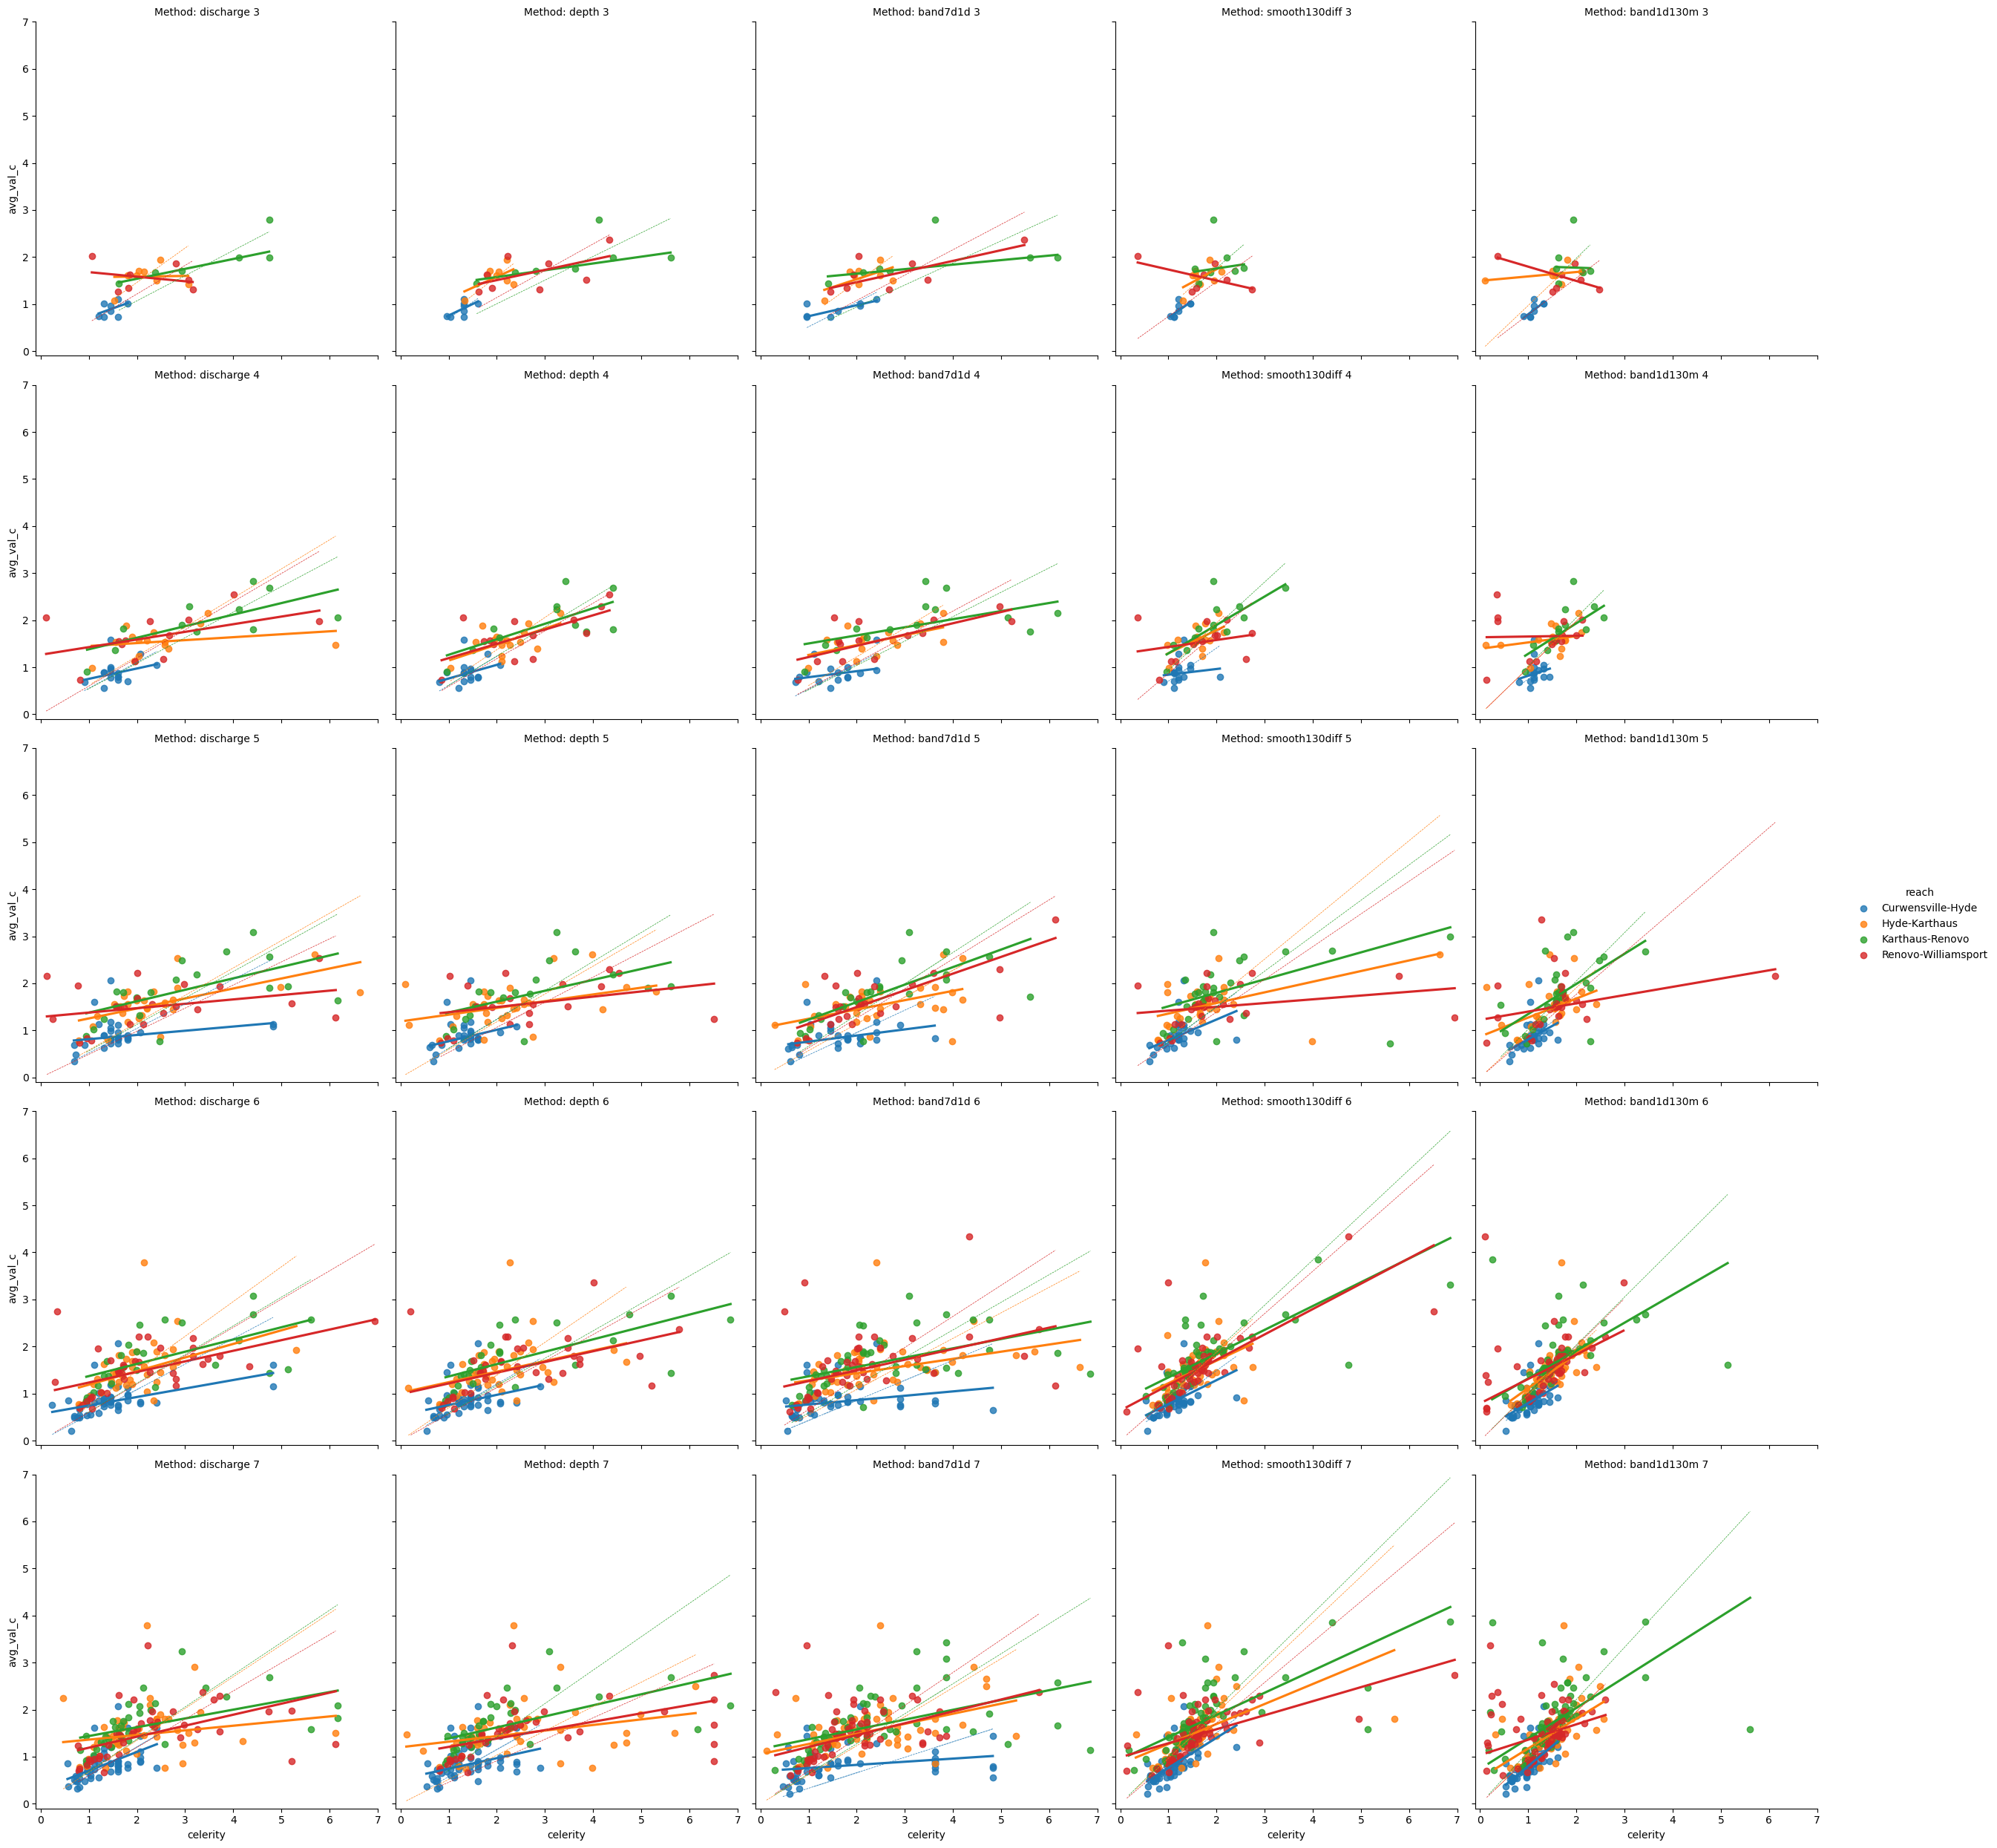

In [64]:
display(md(f"## Plot each method against Validation ONCE"))
# Plot each method against Validation ONCE

# Create a subset of methods to display
view_methods = ['discharge', 'depth', 'band7d1d','smooth130diff','band1d130m']
levels = [3, 4, 5, 6, 7]

plausible_mask = output['celerity'].between(0.1, 7.0)
plot_data = (output.loc[plausible_mask]
                   .loc[(view_methods, levels),["avg_val_c", "celerity"]].dropna()
                   .reset_index()
            )

g = sns.lmplot(  # relplot is just a scatter; regplot adds least squares line
    data=plot_data, y="avg_val_c", x="celerity",
    col="method", hue="reach", #style="reach",
    row="level",
    #lowess=True,
    robust=True, ci=None,
    #line_kws={'color':'C1'},
    facet_kws={'xlim':[-0.1,7], 'ylim':[-0.1,7]},
)
def diag(**kwargs):
    return sns.lineplot(x=[0,7], y=[0,7],color='k', marker=None,
            linestyle='--', linewidth=0.5)

def robust_line(x, y, **kwargs):
    resrlm = sm.RLM(y, x).fit()
    rlm_slope = resrlm.params.iloc[0]
    rlm_y = x * rlm_slope
    rlm_mae = np.mean(np.abs(rlm_y - x))
    return sns.lineplot(x=x, y=rlm_y, color=kwargs['color'], marker=None,
            linestyle='--', linewidth=0.5, label=f"robust MAE: {rlm_mae}")

(g
  .set_axis_labels("Cross-Correlation Celerity (m/s)","Validation Celerity (m/s)")
  .set_titles("Method: {col_name} {row_name}")
  .tight_layout(w_pad=0.05)
  .map(robust_line, "celerity","avg_val_c" )
)
#Map a robust fitted line to row 4, col 3
#g.axes[4,3].plot(x, resrlm2.fittedvalues, "k-", label="RLM")

C:\Users\marti\AppData\Local\Temp\ipykernel_10232\3010405030.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  plot_data = output.loc[plausible_mask].loc[('smooth130diff', 7,'Renovo-Williamsport'),['avg_val_c','celerity']].dropna()
C:\Users\marti\AppData\Local\Temp\ipykernel_10232\3010405030.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rlm_slope = resrlm.params[0]


celerity    0.021024
dtype: float64
Slopes:
    RLM: 0.8597221816496688, Theil: 0.6118223487269479, Siegel: 0.6243499466406747
MAE   :
    RLM: 0.23519781058029737, Theil: 0.21134423458087825, Siegel: 0.21881837238068258


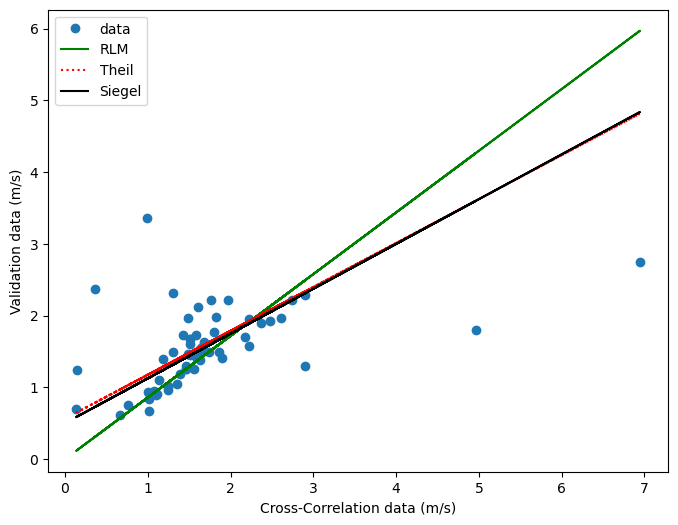

In [65]:
#x="avg_val_c", y="celerity"
plot_data = output.loc[plausible_mask].loc[('smooth130diff', 7,'Renovo-Williamsport'),['avg_val_c','celerity']].dropna()
y=plot_data['avg_val_c']
x=plot_data['celerity']

resrlm = sm.RLM(y, x).fit()
rlm_slope = resrlm.params[0]
rlm_y = x * rlm_slope
rlm_mae = np.mean(np.abs(rlm_y - x))

print(resrlm.bse)
#print(resrlm.mad)


theil_res = theilslopes(y,x)#, method='joint')
theil_y = theil_res.intercept + (theil_res.slope * x)
theil_mae =  np.mean(np.abs(theil_y - x))


siegel_res = siegelslopes(y,x, method='separate')
siegel_y = siegel_res.intercept + (siegel_res.slope * x)
siegel_mae =  np.mean(np.abs(siegel_y - x))

print(f"Slopes:\n    RLM: {rlm_slope}, Theil: {theil_res.slope}, Siegel: {siegel_res.slope}")
print(f"MAE   :\n    RLM: {rlm_mae}, Theil: {theil_mae}, Siegel: {siegel_mae}")

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, "o", label="data")
ax.plot(x, resrlm.fittedvalues, "g-", label="RLM")
ax.plot(x, theil_y, "r:", label="Theil")
ax.plot(x, siegel_y, "k-", label="Siegel")
ax.set_xlabel('Cross-Correlation data (m/s)')
ax.set_ylabel('Validation data (m/s)')
legend = ax.legend(loc="best")

In [66]:
resrlm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:              avg_val_c   No. Observations:                   61
Model:                            RLM   Df Residuals:                       60
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 28 Jun 2025                                         
Time:                        17:55:42                                         
No. Iterations:                    24                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
celerity       0.8597      0.021     40.893      0.000       0.819       0.901
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [67]:
resrlm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Robust linear model
==========================================================
Model:              RLM              Df Residuals: 60     
Dependent Variable: avg_val_c        Norm:         HuberT 
Date:               2025-06-28 17:55 Scale Est.:   mad    
No. Observations:   61               Cov. Type:    H1     
Df Model:           0                Scale:        0.23440
-----------------------------------------------------------
          Coef.   Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------
celerity  0.8597    0.0210  40.8932  0.0000  0.8185  0.9009
==========================================================

"""

                    Robust linear Model Regression Results                    
Dep. Variable:              avg_val_c   No. Observations:                   61
Model:                            RLM   Df Residuals:                       59
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 28 Jun 2025                                         
Time:                        17:55:42                                         
No. Iterations:                    15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9877      0.098     10.089      0.0

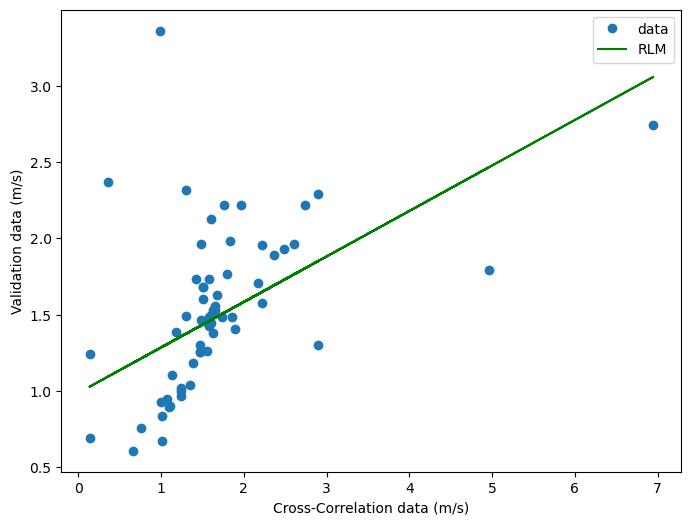

In [68]:
from statsmodels.formula.api import ols, rlm
rlm_model = rlm("avg_val_c ~ celerity", plot_data).fit()
x = plot_data['celerity']
y = plot_data['avg_val_c']
print(rlm_model.summary())
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, "o", label="data")
ax.plot(x, rlm_model.fittedvalues, "g-", label="RLM")
ax.set_xlabel('Cross-Correlation data (m/s)')
ax.set_ylabel('Validation data (m/s)')
legend = ax.legend(loc="best")


                    Robust linear Model Regression Results                    
Dep. Variable:              avg_val_c   No. Observations:                   61
Model:                            RLM   Df Residuals:                       60
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 28 Jun 2025                                         
Time:                        17:55:42                                         
No. Iterations:                    24                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
celerity       0.8597      0.021     40.893      0.0

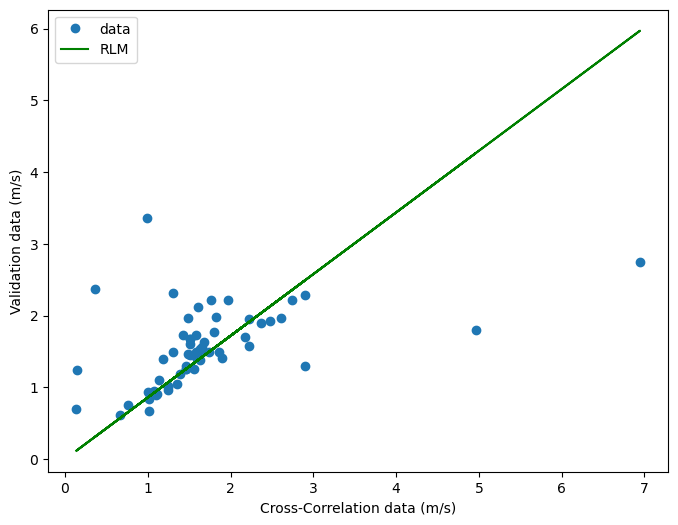

In [69]:
# No Intercept   -1
rlm_model2 = rlm("avg_val_c ~ celerity -1", plot_data).fit()
x = plot_data['celerity']
y = plot_data['avg_val_c']
print(rlm_model2.summary())
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, "o", label="data")
ax.plot(x, rlm_model2.fittedvalues, "g-", label="RLM")
ax.set_xlabel('Cross-Correlation data (m/s)')
ax.set_ylabel('Validation data (m/s)')
legend = ax.legend(loc="best")
